# Cluster NYC Business History

## Author: Vishwajeet Shelar

# Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import zipfile
import seaborn
import matplotlib.pylab as plt
import geopandas as gp
import datetime as dt
from sklearn.cluster import KMeans
from matplotlib import cm
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import AgglomerativeClustering

%matplotlib inline

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
def getzips():
    
    year = []
    for i in range(94, 100, 1):
        year.append(str(i))
    for i in range(0, 10, 1):
        year.append('0'+str(i))
    for i in range(10, 15, 1):
        year.append(str(i))
    
    flag = 0
    for i in year:
        if not os.path.isfile(os.getenv("PUIDATA") + "/" + "zbp" + i + "totals.zip"):
            if os.path.isfile("zbp" + i + "totals.zip"):
                print ('File in current directory, moving it to PUIdata')
                if os.system("mv " + "zbp" + i + "totals.zip " + os.getenv("PUIDATA")):
                    print ("Error moving file zbp" + i + "totals.zip, Please check!")
            else:
                flag = 1

    if flag == 1:
        !for ((y=93; y<=99; y+=1)); do wget \
        ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp$y\totals.zip; done
        
        !for ((y=0; y<=1; y+=1)); do wget \
        ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp0$y\totals.zip; done

        !for ((y=2; y<=9; y+=1)); do wget \
        ftp://ftp.census.gov/econ200$y\\/CBP_CSV/zbp0$y\\totals.zip; done

        !for ((y=10; y<=15; y+=1)); do wget\
        ftp://ftp.census.gov/econ20$y\/CBP_CSV/zbp$y\totals.zip; done

        for i in year:
            if os.system("mv " + "zbp" + i + "totals.zip " + os.getenv("PUIDATA")):
                print ("Error moving file!, Please check!")

### One final check:
    for i in year:
        if not os.path.isfile(os.getenv("PUIDATA") + "/" + "zbp" + i + "totals.zip"):
            print ("WARNING!!! something is wrong: the file zbp" + i + "totals.zip is not there!")
        else:
            print ("zbp" + i + "totals.zip file is in PUIdata")

In [3]:
getzips()

zbp94totals.zip file is in PUIdata
zbp95totals.zip file is in PUIdata
zbp96totals.zip file is in PUIdata
zbp97totals.zip file is in PUIdata
zbp98totals.zip file is in PUIdata
zbp99totals.zip file is in PUIdata
zbp00totals.zip file is in PUIdata
zbp01totals.zip file is in PUIdata
zbp02totals.zip file is in PUIdata
zbp03totals.zip file is in PUIdata
zbp04totals.zip file is in PUIdata
zbp05totals.zip file is in PUIdata
zbp06totals.zip file is in PUIdata
zbp07totals.zip file is in PUIdata
zbp08totals.zip file is in PUIdata
zbp09totals.zip file is in PUIdata
zbp10totals.zip file is in PUIdata
zbp11totals.zip file is in PUIdata
zbp12totals.zip file is in PUIdata
zbp13totals.zip file is in PUIdata
zbp14totals.zip file is in PUIdata


# Getting NYC ZipCodes

In [16]:
zip_codes = gp.read_file('NYC_zip_codes.geojson')
zip_codes.head()

,@id,BLDGpostalCode,CTY_FIPS,OBJECTID,PO_NAME,STATE,ST_FIPS,Shape_Area,Shape_Leng,borough,geometry,postalCode
0,http://nyc.pediacities.com/Resource/PostalCode...,0,081,1,Jackson Heights,NY,36,2.016328e+07,20624.692317,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372
1,http://nyc.pediacities.com/Resource/PostalCode...,0,081,2,Glen Oaks,NY,36,2.260653e+07,23002.816039,Queens,POLYGON ((-73.71068374074007 40.75004039450917...,11004
2,http://nyc.pediacities.com/Resource/PostalCode...,0,081,3,New Hyde Park,NY,36,6.269333e+06,15749.161511,Queens,POLYGON ((-73.70098278625547 40.73889569923034...,11040
3,http://nyc.pediacities.com/Resource/PostalCode...,0,081,4,Bellerose,NY,36,4.941836e+07,35932.810639,Queens,POLYGON ((-73.72270447144122 40.75373371438336...,11426
4,http://nyc.pediacities.com/Resource/PostalCode...,0,081,5,Fresh Meadows,NY,36,6.938587e+07,38693.565676,Queens,POLYGON ((-73.81088634744755 40.72717187575918...,11365


In [17]:
zip_codes = zip_codes.drop([ u'@id', u'BLDGpostalCode', u'PO_NAME', u'CTY_FIPS', u'ST_FIPS',
                             u'STATE', u'OBJECTID', u'Shape_Area', u'borough', u'Shape_Leng'], 
                           axis = 1)
zip_codes = zip_codes.rename(columns={'postalCode' : 'zip_code'})
zip_codes['zip_code'] = pd.to_numeric(zip_codes['zip_code'], errors = 'coerce')
zip_codes.head()

,geometry,zip_code
0,POLYGON ((-73.86942457284175 40.74915687096787...,11372
1,POLYGON ((-73.71068374074007 40.75004039450917...,11004
2,POLYGON ((-73.70098278625547 40.73889569923034...,11040
3,POLYGON ((-73.72270447144122 40.75373371438336...,11426
4,POLYGON ((-73.81088634744755 40.72717187575918...,11365


# Cleaning NYC Business data from year 1994 to 2014 and merging with NYC Zip Code data

In [18]:
year = []
for i in range(94, 100, 1):
    year.append(str(i))
for i in range(0, 10, 1):
    year.append('0'+str(i))
for i in range(10, 15, 1):
    year.append(str(i))

In [19]:
for i in year:
    zf = zipfile.ZipFile(os.getenv("PUIDATA") + "/" + "zbp" + i + "totals.zip")
    temp = pd.read_csv(zf.open('zbp'+i+'totals.zip'.replace('.zip','.txt')))
    temp.columns = map(str.lower, temp.columns)
    temp = temp[['zip', 'est']]
    year = dt.datetime.strptime(str(i), '%y').year
    temp.rename(columns={'est': str(year), 'zip':'zip_code'}, inplace=True)
    zip_codes = zip_codes.merge(temp, on = 'zip_code', how = 'inner')

# Standardizing the time series

In [20]:
ts_mean = zip_codes.iloc[:,range(2,23)].mean(axis = 1)
ts_std = zip_codes.iloc[:,range(2,23)].std(axis = 1)
zip_codes.iloc[:,range(2,23)] = zip_codes.iloc[:,range(2,23)].apply(lambda x: (x-ts_mean)/ts_std)
zip_codes.head()

,geometry,zip_code,1994,1995,1996,1997,1998,1999,2000,2001,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
0,POLYGON ((-73.86942457284175 40.74915687096787...,11372,-1.650515,-1.607088,-1.259673,-1.154208,-0.893647,-0.738551,-0.533825,-0.540029,...,0.272673,0.198227,0.309896,0.266469,0.477400,0.831018,0.942687,1.420382,1.637516,1.693350
1,POLYGON ((-73.71068374074007 40.75004039450917...,11004,-0.974535,-1.248013,-1.794968,-1.065695,-0.974535,-1.339172,-1.202433,-0.518739,...,0.438432,0.484012,1.030967,0.529592,0.803069,0.620751,0.301694,1.167706,1.167706,1.577923
2,POLYGON ((-73.70098278625547 40.73889569923034...,11040,-0.118051,-0.234030,-1.379327,-1.248850,-1.248850,-1.161866,-1.161866,-1.292342,...,0.157401,0.345867,0.838780,1.056241,0.650313,0.925765,0.838780,1.157723,1.578149,1.505662
3,POLYGON ((-73.72270447144122 40.75373371438336...,11426,3.212291,-0.444253,-0.785986,-1.161892,-0.991026,-0.512600,-0.649293,-0.512600,...,-0.205040,-0.205040,-0.136693,-0.205040,0.170867,0.546773,0.820159,1.161892,0.888506,0.956853
4,POLYGON ((-73.81088634744755 40.72717187575918...,11365,-1.332578,-1.549090,-1.454366,-0.926619,-1.102534,-0.967215,-0.507127,-0.222956,...,0.183004,0.237132,0.358920,0.345388,0.507772,0.710751,1.170839,1.197903,1.671522,1.901566


In [7]:
print 'After standardizing the time series, std. deviation along all zip codes: {0}\
\nAfter standardizing the time series, mean along all zip codes: {1}(~0)'.format(
    zip_codes.iloc[:,range(2,23)].std(axis = 1).sum()/len(zip_codes),
    zip_codes.iloc[:,range(2,23)].mean(axis = 1).sum()/len(zip_codes))

After standardizing the time series, std. deviation along all zip codes: 1.0
After standardizing the time series, mean along all zip codes: -2.35068968612e-17(~0)


# Clustering the data

In [8]:
X = zip_codes.iloc[:, range(2,23)]
range_n_clusters = range(2,10)
for n_clusters in range_n_clusters:
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =2, the average silhouette_score is :0.572142801777
For n_clusters =3, the average silhouette_score is :0.541435020202
For n_clusters =4, the average silhouette_score is :0.495601550463
For n_clusters =5, the average silhouette_score is :0.478801351965
For n_clusters =6, the average silhouette_score is :0.234252779225
For n_clusters =7, the average silhouette_score is :0.269653212641
For n_clusters =8, the average silhouette_score is :0.1408578891
For n_clusters =9, the average silhouette_score is :0.20686549319


### As per the Silhouette score, the optimal number of clusters can be 2. I am also using number of clusters = 5 for the analysis, since the silhoutte value has drastically reduced for 6 clusters (almost by 0.20) and the difference in score in between 2 and 5 clusters is small compared to the score difference between clusters 5 and 6. 

# Clustering using K-means

## Number of Clusters = 2

In [9]:
#KMeans cluster
kmeans_cluster2 = KMeans(2, random_state= 125).fit(zip_codes.iloc[:, range(2,23)])
centers2 = kmeans_cluster2.cluster_centers_
zip_codes['km2_labels'] = kmeans_cluster2.labels_

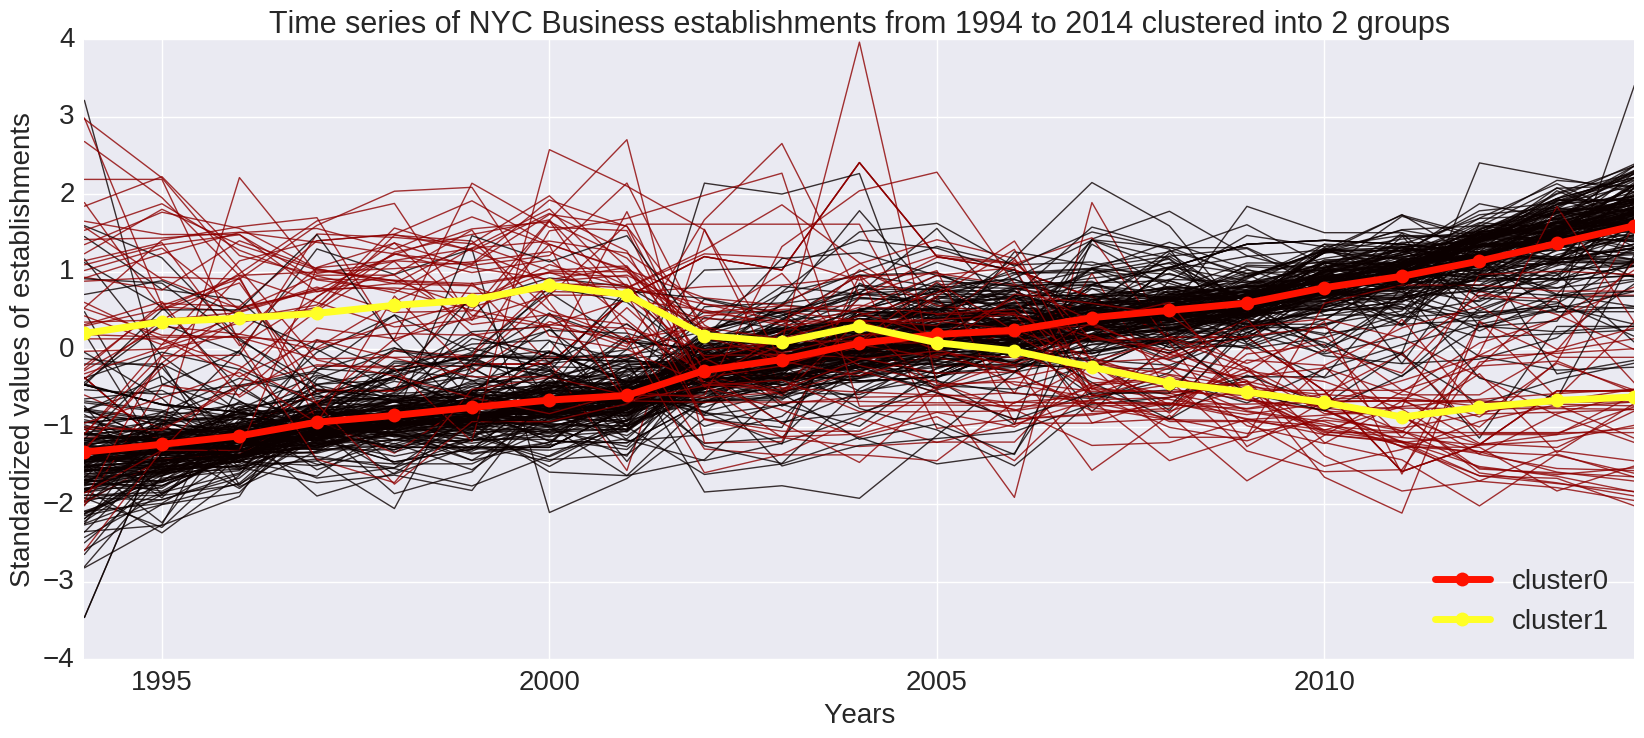

In [10]:
fig = plt.figure(figsize=(20,8))
ax = fig.gca()
for i in range(len(zip_codes)):
    ax.plot(range(1994,2015), zip_codes.iloc[i,range(2,23)], 
            '-', lw = 1, alpha = 0.8, c=cm.hot(zip_codes.km2_labels[i]*50))

lines = range(len(centers2))    
for i in range(len(centers2)):
    line, = plt.plot(range(1994,2015),centers2[i], 
                    '.-', ms = 20, lw = 5, c=cm.hot(((i+1)*100)), 
                     label = 'cluster'+ str(i))
    lines[i] = (line)

plt.legend(handles=[lines[i] for i in range(len(centers2))], fontsize = 20, 
           loc = 'best')
plt.xlim(1994,2014)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Years", fontsize=20)
plt.ylabel("Standardized values of establishments", fontsize=20)
plt.title('Time series of NYC Business establishments from 1994 to 2014 clustered into 2 groups', 
          fontsize=22)

plt.show()

## Figure1: The above plot shows the time series of "number of business establishments" in different zipcodes in NYC from 1994 to 2014. The time series of the zipcodes is standarized and clustered into 2 groups. The clustering seems to be as per the trend observed in the mean number of establishments in the clustered zipcodes.   

## Number of Clusters = 5

In [11]:
#KMeans cluster
kmeans_cluster5 = KMeans(5, random_state= 12).fit(zip_codes.iloc[:, range(2,23)])
centers5 = kmeans_cluster5.cluster_centers_
zip_codes['km5_labels'] = kmeans_cluster5.labels_

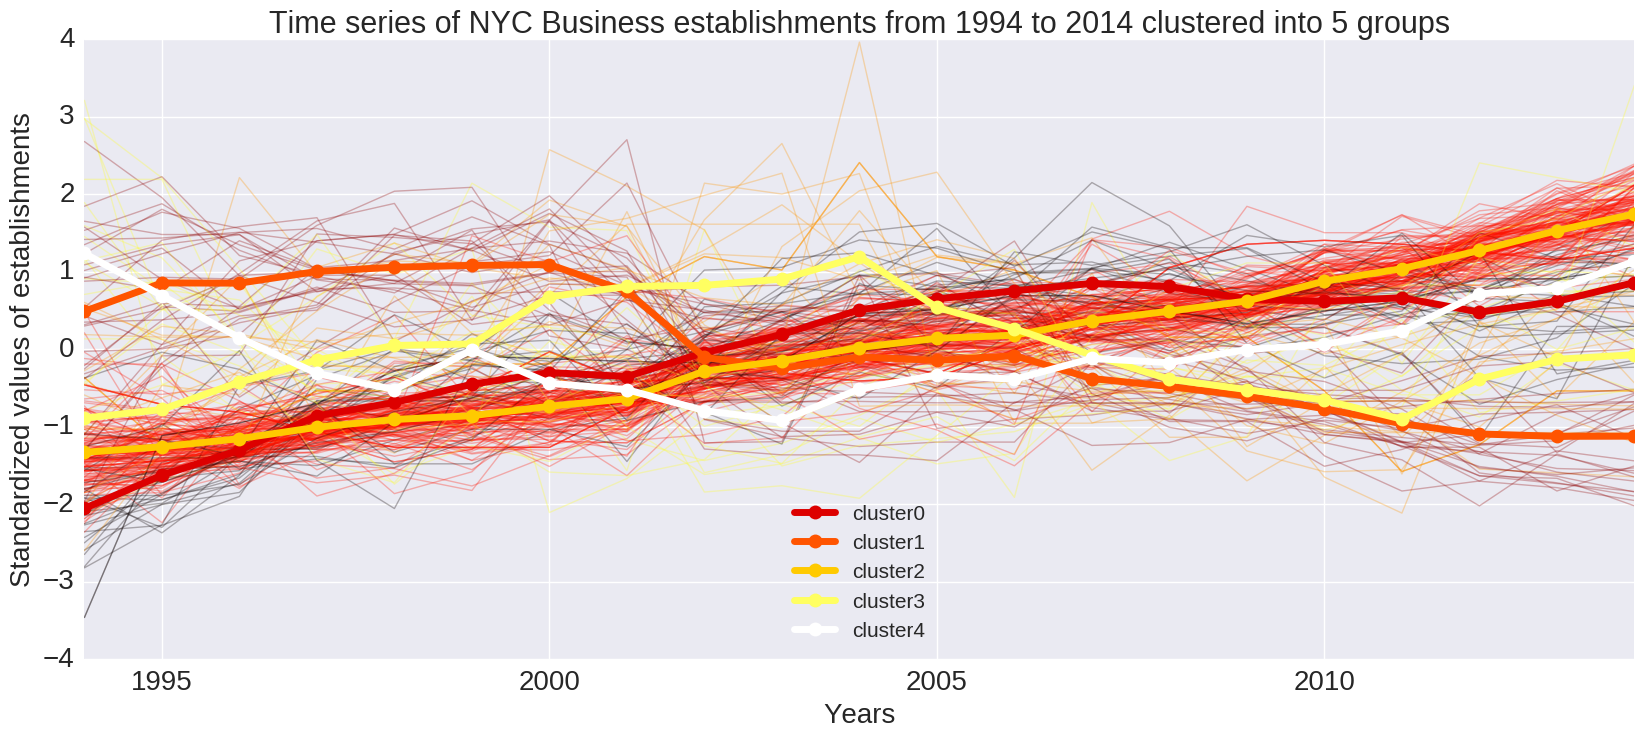

In [12]:
fig = plt.figure(figsize=(20,8))
ax = fig.gca()
for i in range(len(zip_codes)):
    ax.plot(range(1994,2015), zip_codes.iloc[i,range(2,23)], 
            '-', lw = 1, alpha = 0.3, c=cm.hot(zip_codes.km5_labels[i]*50))

lines = range(len(centers5))    
for i in range(len(centers5)):
    line, = plt.plot(range(1994,2015),centers5[i], 
                    '.-', ms = 20, lw = 5, c=cm.hot(((i+1)*80 - (i*35))), 
                     label = 'cluster'+ str(i))
    lines[i] = (line)

plt.legend(handles=[lines[i] for i in range(len(centers5))], fontsize = 15, 
           loc = 'best')
plt.xlim(1994,2014)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Years", fontsize=20)
plt.ylabel("Standardized values of establishments", fontsize=20)
plt.title('Time series of NYC Business establishments from 1994 to 2014 clustered into 5 groups', 
          fontsize=22)

plt.show()

## Figure2: The above plot shows the time series of "number of business establishments" in different zipcodes in NYC from 1994 to 2014. The time series of the zipcodes is standarized and clustered into 5 groups. The clustering in this plot seems to be as per the trend observed in the mean number of establishments in the clustered zipcodes but at more granular level than it was with the 2 clusters as seen in Figure 1

# Cluster the data using Agglomerative Clustering

## Number of Clusters = 2

In [13]:
agc2 = AgglomerativeClustering(n_clusters=2, 
                              compute_full_tree=True).fit(zip_codes.iloc[:, range(2,23)])
agg2_labels = agc2.labels_
zip_codes['agg2_labels'] = agc2.labels_

## Number of Clusters = 5

In [14]:
agc5 = AgglomerativeClustering(n_clusters=5, 
                              compute_full_tree=True).fit(zip_codes.iloc[:, range(2,23)])
agg5_labels = agc5.labels_
zip_codes['agg5_labels'] = agc5.labels_

# Visualizing the clustered Zipcodes

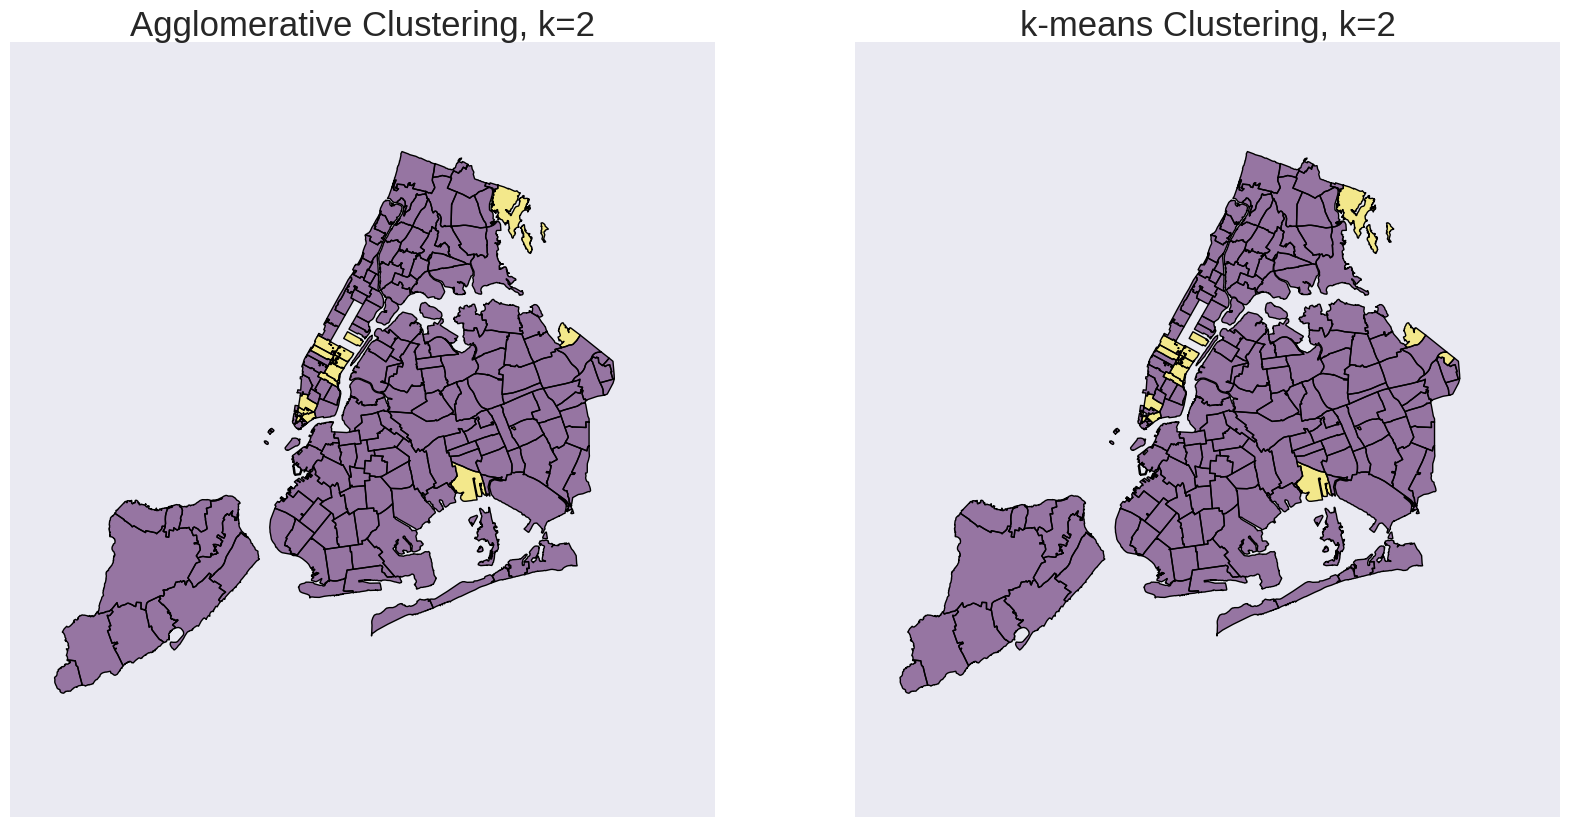

In [15]:
fig = plt.figure(figsize=(20,10))
ax1, ax2 = fig.add_subplot(121), fig.add_subplot(122)
zip_codes.plot(cmap =cm.viridis, column='agg2_labels', ax=ax1)
ax1.set_title("Agglomerative Clustering, k=2", fontsize=25)
ax1.grid()
ax1.set_xticks([])
ax1.set_yticks([])

zip_codes.plot(cmap =cm.viridis, column='km2_labels', ax=ax2)
ax2.set_title("k-means Clustering, k=2", fontsize=25)
ax2.grid()
ax2.set_xticks([])
ax2.set_yticks([])

plt.show()

## Figure 3: Maps of clustered zip codes from the NYC business data. The clusters created by the K-means and Agglomerative clustering algorithms are almost same. The small difference is present maybe because of the clustering techniques. The yellow part in the map above corresponds to the cluster 1 in Figure 1.(yellow line) i.e less increase in number of business establishments in areas around midtown, downtown manhattan and some areas in bronx, queens and brooklyn, this observation can be useful to further investigate the reason for increase in business in other areas; factors like reduction in crime can be analysed    

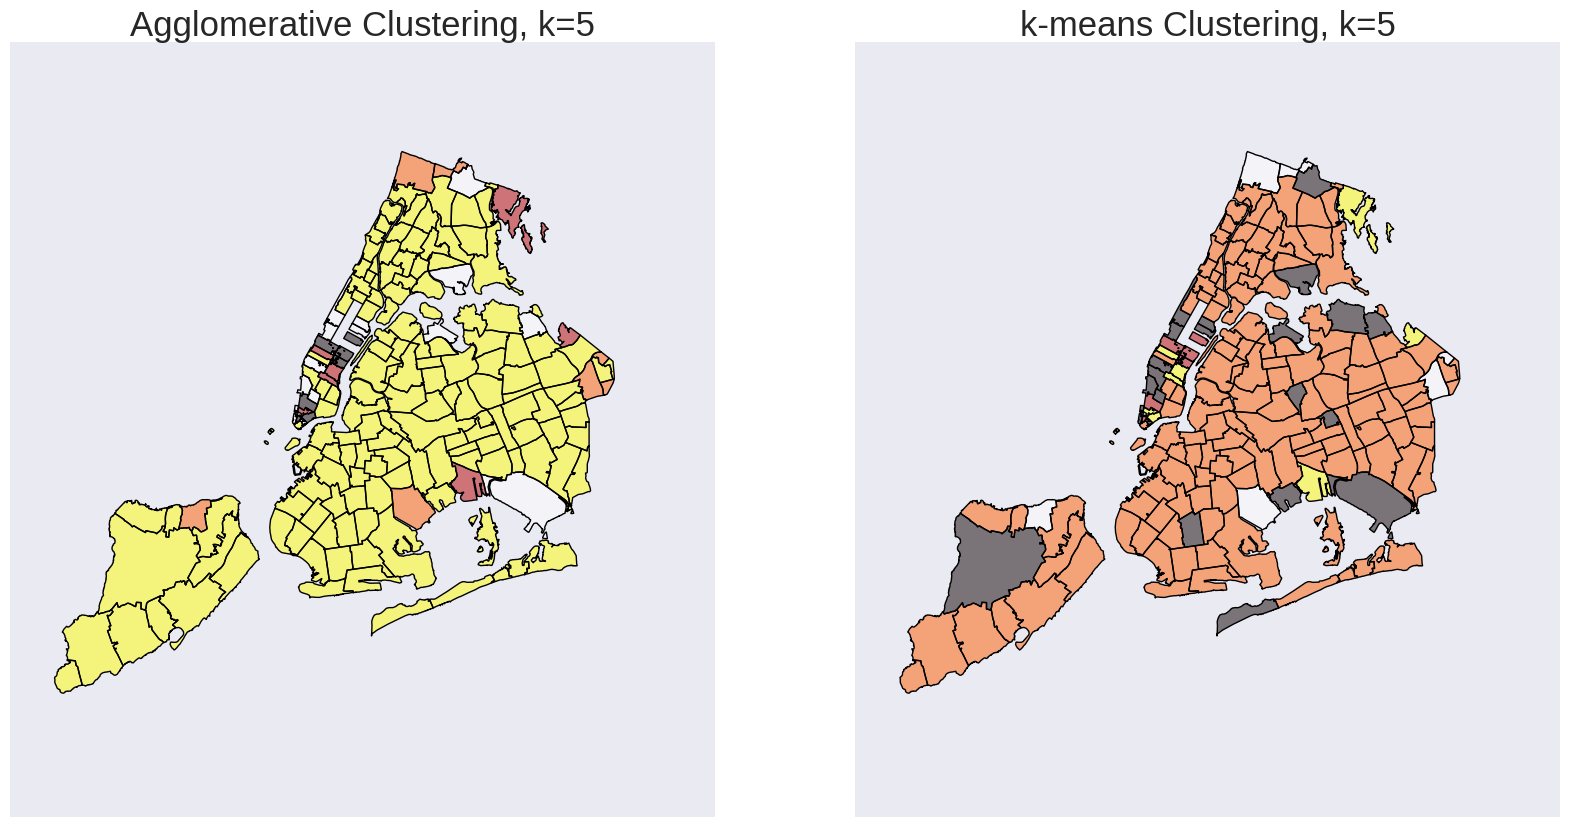

In [16]:
fig = plt.figure(figsize=(20,10))
ax1, ax2 = fig.add_subplot(121), fig.add_subplot(122)
zip_codes.plot(cmap =cm.hot, column='agg5_labels', ax=ax1)
ax1.set_title("Agglomerative Clustering, k=5", fontsize=25)
ax1.grid()
ax1.set_xticks([])
ax1.set_yticks([])

zip_codes.plot(cmap =cm.hot, column='km5_labels', ax=ax2)
ax2.set_title("k-means Clustering, k=5", fontsize=25)
ax2.grid()
ax2.set_xticks([])
ax2.set_yticks([])
plt.show()

## Figure 4: Maps of clustered zip codes from the NYC business data. The clusters created by the K-means and Agglomerative clustering algorithms have some zipcodes which are similarly grouped. Some clusters which are similar in both maps are the one which are located near LaGuardia Airport, JFK Airport, business establishment trends at the airports can follow a similar path, this can be further analysed using more data. 